In [6]:
import random

import numpy as np
from pymoo.problems import get_problem
from pymoo.visualization.scatter import Scatter
from tqdm import tqdm

from archive import ParetoArchive, Grid, numpy_dominates

In [7]:
def MOPSO(problem, low_bound, high_bound, max_iter, pop_size, archive_size, grid_size, w_inertia, rep_div):
    # Initialize all needed containers
    grid = Grid(grid_size)
    grid_func = lambda x: grid.calculate(x)
    archive = ParetoArchive(archive_size, crowding_function=grid_func, add_item_before_crowding=True)

    positions = np.random.uniform(low_bound, high_bound, size=(pop_size, problem.n_var))
    fitnesses = problem.evaluate(positions)
    velocities = np.zeros(shape=(pop_size, problem.n_var))
    p_bests = positions.copy()
    p_best_fits = fitnesses.copy()

    archive.add(positions, fitnesses)
    grid.calculate(archive.items)

    for step in tqdm(range(max_iter)):
        print("Step %d" % step)
        for i in range(problem.n_obj):
            print("mean: %.3f, min: %.3f, max: %.3f" % (np.average(fitnesses[:, i], axis=0),
                                                        np.min(fitnesses[:, i], axis=0),
                                                        np.max(fitnesses[:, i], axis=0)))

        # Perform velocity update
        r_1 = np.random.uniform(0.0, 1.0, size=(pop_size, 1))
        r_2 = np.random.uniform(0.0, 1.0, size=(pop_size, 1))

        # Calculate the reps as described in paper
        item_div_fit = []
        item_div_values = list(grid.item_div.values())
        for entry in item_div_values:
            item_div_fit.append(rep_div / len(entry))

        item_div_prob = list(map(lambda x: x / sum(item_div_fit), item_div_fit))
        item_div_idxs = list(range(len(item_div_prob)))
        grid_picks = np.random.choice(item_div_idxs, pop_size, True, p=item_div_prob)
        reps = []
        for entry in grid_picks:
            reps.append(random.sample(item_div_values[entry], 1)[0])

        reps = np.array(reps)

        inertia = w_inertia * velocities
        cognitive = r_1 * (p_bests - positions)
        social = r_2 * (reps - positions)

        velocities = inertia + cognitive + social

        # Update positions
        positions += velocities
        positions = positions.clip(low_bound, high_bound)

        # Calculate fitnesses
        fitnesses = problem.evaluate(positions)

        # Update archive
        archive.add(positions, fitnesses)
        grid.calculate(archive.items)

        # Update personal bests
        dominates = numpy_dominates(fitnesses, p_best_fits)
        p_best_fits[dominates] = fitnesses[dominates].copy()
        p_bests[dominates] = positions[dominates].copy()
    return archive.items

In [8]:
np.seterr('raise')  # Used for debugging, and it seems code was repaired.
problem = get_problem("zdt3")
# Must change the problem to -f(x) since MOPSO assumes maximization.
tmp = problem.evaluate
problem.evaluate = lambda x: -1 * tmp(x)

In [9]:
archive = MOPSO(problem, 0.0, 1.0, 100, 40, 200, 5, 0.4, 30)

100%|██████████| 100/100 [00:00<00:00, 557.60it/s]

Step 0
mean: -0.565, min: -0.990, max: -0.085
mean: -3.790, min: -5.586, max: -2.103
Step 1
mean: -0.442, min: -0.919, max: -0.094
mean: -3.860, min: -5.529, max: -2.195
Step 2
mean: -0.442, min: -0.804, max: -0.058
mean: -3.543, min: -5.659, max: -2.252
Step 3
mean: -0.394, min: -0.830, max: -0.111
mean: -3.390, min: -5.289, max: -2.259
Step 4
mean: -0.351, min: -0.865, max: -0.000
mean: -3.519, min: -4.743, max: -1.896
Step 5
mean: -0.451, min: -1.000, max: -0.030
mean: -3.293, min: -4.741, max: -2.327
Step 6
mean: -0.510, min: -1.000, max: -0.226
mean: -3.081, min: -4.061, max: -1.788
Step 7
mean: -0.434, min: -0.835, max: -0.069
mean: -3.039, min: -4.241, max: -2.041
Step 8
mean: -0.349, min: -0.751, max: -0.000
mean: -3.245, min: -4.281, max: -2.158
Step 9
mean: -0.345, min: -1.000, max: -0.000
mean: -3.221, min: -4.701, max: -2.260
Step 10
mean: -0.311, min: -0.817, max: -0.000
mean: -3.294, min: -4.920, max: -2.252
Step 11
mean: -0.346, min: -0.671, max: -0.002
mean: -3.041, min

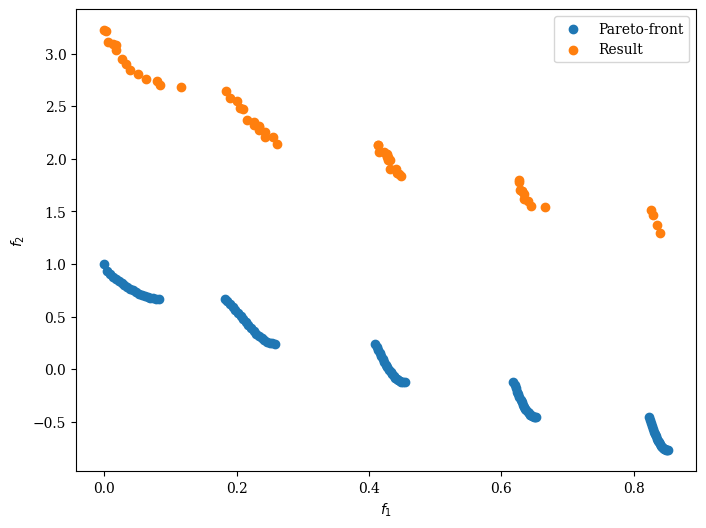

In [10]:
pf = problem.pareto_front()
Scatter(legend=True).add(pf, label="Pareto-front").add(np.array([entry['fit'] * -1 for entry in archive]),
                                                       label="Result").show()